In [29]:
import duckdb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors

In [30]:
import findspark
findspark.init()

In [31]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder.appName("Analysis5pyspark").getOrCreate()

# Verify Spark is running
print(f"Spark version: {spark.version}")

Spark version: 3.5.4


In [32]:
file_path = "../data/2022new.parquet"
df = spark.read.parquet(file_path)
df.show(5)
df.printSchema()

+-------------------+--------------------+-----------+----+----+
|          timestamp|             user_id|pixel_color|   x|   y|
+-------------------+--------------------+-----------+----+----+
|2022-04-04 00:53:51| 6321273219385959791|    #00CCC0| 826|1048|
|2022-04-04 00:53:53|16067775443321929099|    #94B3FF| 583|1031|
|2022-04-04 00:53:54|16695610587236035986|    #6A5CFF|1873| 558|
|2022-04-04 00:54:57|16727013599938433751|    #009EAA|1627| 255|
|2022-04-04 00:55:16|14956368908677691579|    #94B3FF|  49|1478|
+-------------------+--------------------+-----------+----+----+
only showing top 5 rows

root
 |-- timestamp: timestamp_ntz (nullable = true)
 |-- user_id: decimal(20,0) (nullable = true)
 |-- pixel_color: string (nullable = true)
 |-- x: short (nullable = true)
 |-- y: short (nullable = true)



In [33]:
df.createOrReplaceTempView("my_table")

result0 = spark.sql("""SELECT timestamp
                        FROM my_table
                        ORDER BY timestamp ASC
                        LIMIT 1;""")
result0.show()


+-------------------+
|          timestamp|
+-------------------+
|2022-04-01 12:44:10|
+-------------------+



In [34]:
from datetime import timedelta

delta1 = timedelta(hours=82, minutes=4)
delta2 = timedelta(hours=82, minutes=15)
result0_value = result0.collect()[0][0]
whiteout_begin = result0_value + delta1
whiteout_chunk1 = result0_value + delta2
print(whiteout_begin)
print(whiteout_chunk1)

2022-04-04 22:48:10
2022-04-04 22:59:10


In [ ]:
from pyspark.sql.functions import concat, lit

result1 = spark.sql(f"""SELECT x, y, COUNT(*) AS coordinate_count
                        FROM my_table
                        WHERE timestamp >= '{whiteout_begin}'
                        GROUP BY x, y
                        ORDER BY coordinate_count DESC
                        LIMIT 11;""")

df1 = result1.withColumn("coord", concat(lit("("), result1["x"], lit(", "), result1["y"], lit(")")))
df1.show()


+----+----+----------------+------------+
|   x|   y|coordinate_count|       coord|
+----+----+----------------+------------+
|   0|   0|           28298|      (0, 0)|
|1999|1999|            6049|(1999, 1999)|
|   0|1999|            5567|   (0, 1999)|
|1999|   0|            3898|   (1999, 0)|
|1000|1000|            3303|(1000, 1000)|
| 727| 727|            1561|  (727, 727)|
|  69| 420|            1160|   (69, 420)|
|  69|  69|            1117|    (69, 69)|
|   1|   0|             943|      (1, 0)|
|   1|   1|             806|      (1, 1)|
| 420|  69|             736|   (420, 69)|
+----+----+----------------+------------+



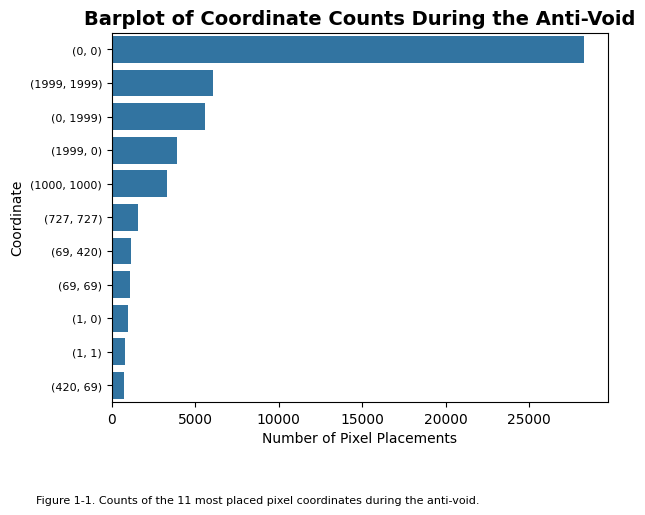

In [36]:
df1_pd = df1.toPandas()

ax = (sns.barplot(x='coordinate_count', y='coord', data=df1_pd))

ax.set_xlabel("Number of Pixel Placements")
ax.set_ylabel("Coordinate")

plt.yticks(fontsize=8)

plt.title("Barplot of Coordinate Counts During the Anti-Void", fontsize=14, fontweight='bold')
plt.figtext(0.7, -0.1, "Figure 1-1. Counts of the 11 most placed pixel coordinates during the anti-void.", wrap=False, ha="right", fontsize=8)
plt.show()

In [37]:
result2 = duckdb.query(f"""SELECT x, y, timestamp
                        FROM '{file_path}'
                        WHERE timestamp >= '{whiteout_begin}';""")
                      
df2 = result2.to_df()

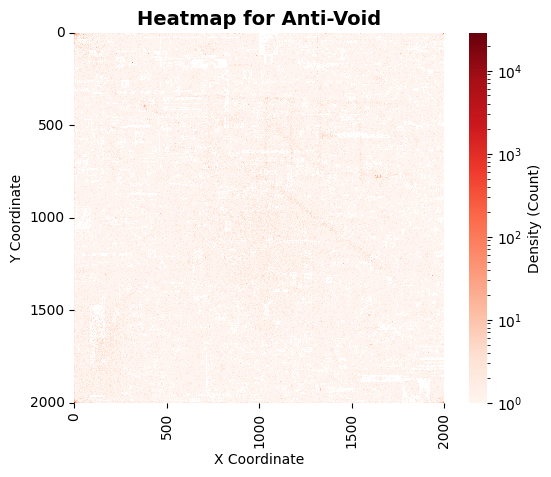

In [38]:
heatmap_data = np.zeros((2000, 2000), dtype=int)
np.add.at(heatmap_data, (df2['y'].values, df2['x'].values), 1)

ax = sns.heatmap(
        heatmap_data, cmap="Reds", square=True, 
        norm=colors.LogNorm(vmin=1, vmax=heatmap_data.max()), 
        cbar_kws={'label': 'Density (Count)'}  # Improve the color legend
    )

ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")

plt.xticks(ticks=np.linspace(0, 2000, 5), labels=np.linspace(0, 2000, 5).astype(int))
plt.yticks(ticks=np.linspace(0, 2000, 5), labels=np.linspace(0, 2000, 5).astype(int))

plt.title("Heatmap for Anti-Void", fontsize=14, fontweight='bold')
plt.show()

/var/folders/wn/1h4z_5y959g0lxlcphs4q6bc0000gn/T/ipykernel_47978/3416723492.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['time_bin'] = df['timestamp'].dt.floor(time_length)


<Figure size 1000x1000 with 0 Axes>

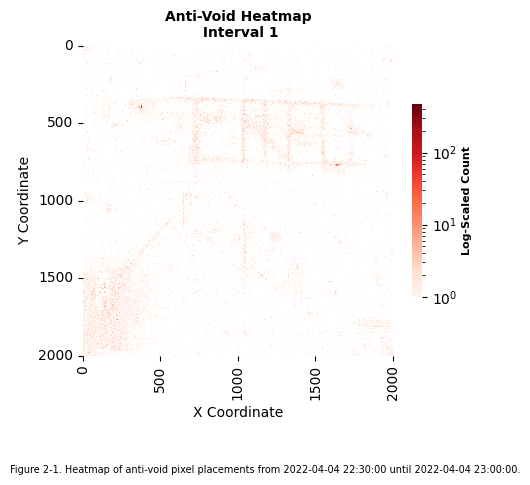

<Figure size 1000x1000 with 0 Axes>

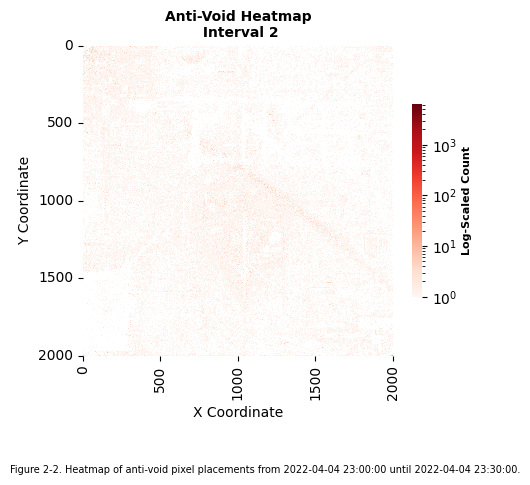

<Figure size 1000x1000 with 0 Axes>

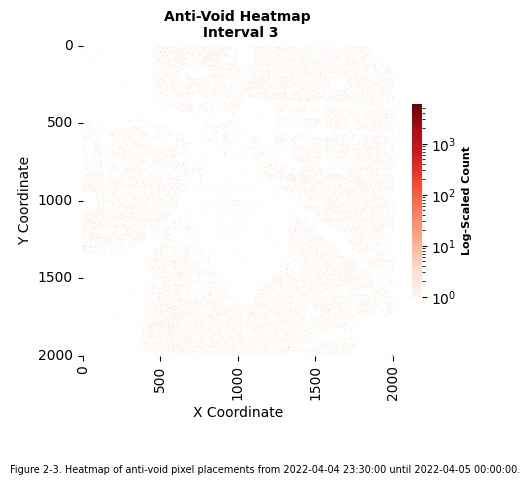

<Figure size 1000x1000 with 0 Axes>

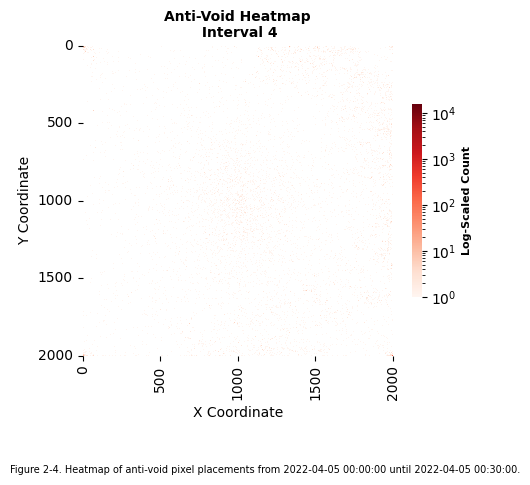

In [ ]:
def heatmap_over_time(df, time_length):
    df['time_bin'] = df['timestamp'].dt.floor(time_length)

    time_bins = df['time_bin'].unique()

    count = 0
    for time_bin in time_bins:
        count +=1
        next_time_bin = time_bin + timedelta(minutes=30)
        plt.figure(figsize=(10, 10))
        
        df_subset = df[df['time_bin'] == time_bin]
        
        heatmap_data = np.zeros((2000, 2000), dtype=int)
        np.add.at(heatmap_data, (df_subset['y'].values, df_subset['x'].values), 1)

        plt.figure(figsize=(5, 5))

        ax = sns.heatmap(
            heatmap_data, cmap="Reds", square=True, 
            norm=colors.LogNorm(vmin=1, vmax=heatmap_data.max()), 
            cbar_kws={'label': 'Density (Count)',
                    'shrink': 0.5}  # Improve the color legend_
        )

        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=10)  # Adjust size of colorbar ticks
        cbar.set_label('Log-Scaled Count', fontsize=8, fontweight='bold')

        ax.set_xlabel("X Coordinate")
        ax.set_ylabel("Y Coordinate")

        plt.xticks(ticks=np.linspace(0, 2000, 5), labels=np.linspace(0, 2000, 5).astype(int))
        plt.yticks(ticks=np.linspace(0, 2000, 5), labels=np.linspace(0, 2000, 5).astype(int))

        plt.title(f"Anti-Void Heatmap\n Interval {count}", fontsize=10, fontweight='bold')

        plt.figtext(1.0, -0.05, f"Figure 2-{count}. Heatmap of anti-void pixel placements from {time_bin} until {next_time_bin}.", wrap=False, ha="right", fontsize=7)

        plt.show()

heatmap_over_time(df2, '30T')



In [40]:
bin_counts = df2['time_bin'].value_counts().sort_index()
print(bin_counts)

time_bin
2022-04-04 22:30:00    1028275
2022-04-04 23:00:00    1954708
2022-04-04 23:30:00    1102677
2022-04-05 00:00:00     320010
Name: count, dtype: int64


In [41]:
result3 = duckdb.query(f"""SELECT x, y, timestamp
                        FROM '{file_path}'
                        WHERE timestamp >= '{whiteout_begin}' and timestamp <= '{whiteout_chunk1}';""")
                      
df3 = result3.to_df()

/var/folders/wn/1h4z_5y959g0lxlcphs4q6bc0000gn/T/ipykernel_47978/3416723492.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['time_bin'] = df['timestamp'].dt.floor(time_length)


<Figure size 1000x1000 with 0 Axes>

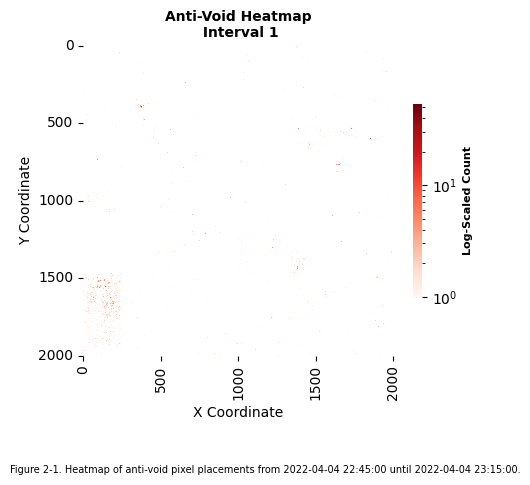

<Figure size 1000x1000 with 0 Axes>

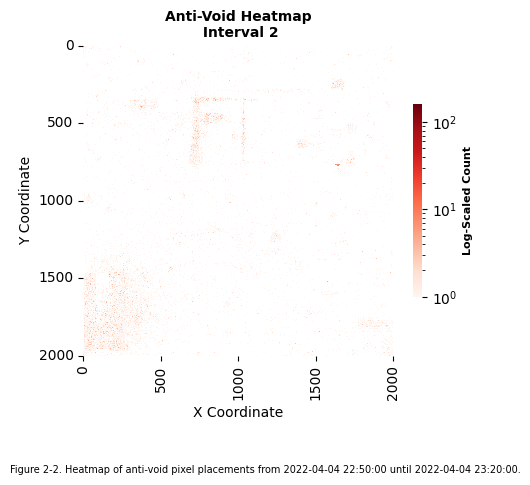

<Figure size 1000x1000 with 0 Axes>

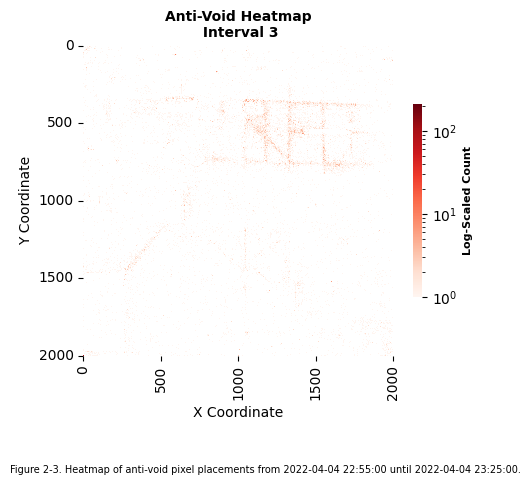

In [42]:
heatmap_over_time(df3, '5T')

In [27]:
result4 = duckdb.query(f"""SELECT x, y, timestamp
                        FROM '{file_path}'
                        WHERE timestamp >= '{whiteout_begin}' AND timestamp <= '{whiteout_chunk1}';""")
                      
df4 = result4.to_df()

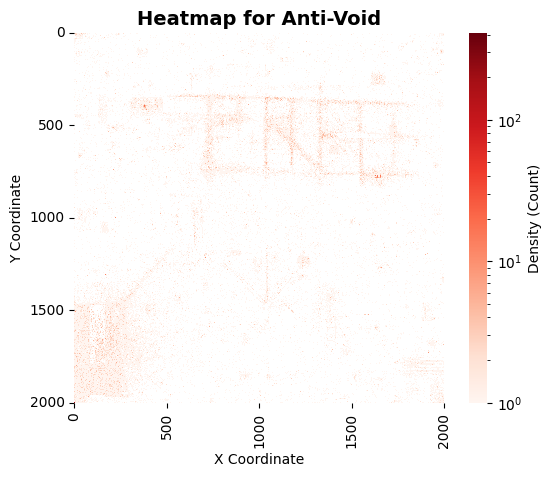

In [28]:
heatmap_data = np.zeros((2000, 2000), dtype=int)
np.add.at(heatmap_data, (df4['y'].values, df4['x'].values), 1)

ax = sns.heatmap(
        heatmap_data, cmap="Reds", square=True, 
        norm=colors.LogNorm(vmin=1, vmax=heatmap_data.max()), 
        cbar_kws={'label': 'Density (Count)'}  
    )

ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")

plt.xticks(ticks=np.linspace(0, 2000, 5), labels=np.linspace(0, 2000, 5).astype(int))
plt.yticks(ticks=np.linspace(0, 2000, 5), labels=np.linspace(0, 2000, 5).astype(int))

plt.title("Heatmap for Anti-Void", fontsize=14, fontweight='bold')
plt.show()